# This is only using the wildfire images from the orange dot and manual csv and dates that don't have clouds csv
## Keras the Sequential model
* Done on Google Colab

In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from skimage.transform import resize
from skimage.io import imshow, imread
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

### Get wildfire dates

In [2]:
#path = '../images/'
path = 'images'
filename = 'wildfires_orange_dot_and_manual.csv'

In [3]:
df_wildfires = pd.read_csv(os.path.join(path, filename))

In [4]:
df_wildfires['date'] = pd.to_datetime(df_wildfires['date'])

<ipython-input-4-bbffe6376b73>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_wildfires['date'] = pd.to_datetime(df_wildfires['date'])


In [5]:
df2_wildfires = df_wildfires.sort_values(by='date')

In [6]:
df_wildfires['ConvertedDate'] = df_wildfires['date'].dt.strftime('%Y-%m-%d')

In [7]:
df_wildfires = df_wildfires.drop(['date'], axis = 1)

In [8]:
df_wildfires = df_wildfires.assign(wildfires=1)

In [9]:
df_wildfires = df_wildfires[['ConvertedDate','wildfires']]

In [10]:
len(df_wildfires)

426

### Get dates with minimal cloud coverage
* no_cloudy_dates_list_1_13_2022.csv

In [11]:
#path = '../images/'
path = 'images/'
filename = 'no_cloudy_dates_list_1_13_2022.csv'

In [12]:
df_no_clouds = pd.read_csv(os.path.join(path, filename))

In [13]:
df_no_clouds['date'] = pd.to_datetime(df_no_clouds['Date'])

In [14]:
df_no_clouds = df_no_clouds.drop(['Unnamed: 0'], axis = 1)

In [15]:
df_no_clouds2 = df_no_clouds.sort_values(by='date')

In [16]:
df_no_clouds = df_no_clouds2.drop(['Date'], axis = 1)

In [17]:
df_no_clouds.dtypes

Clouds             int64
date      datetime64[ns]
dtype: object

In [18]:
df_no_clouds['ConvertedDate'] = df_no_clouds['date'].dt.strftime('%Y-%m-%d')

In [19]:
df_no_clouds = df_no_clouds.drop(['date'], axis = 1)

In [20]:
len(df_no_clouds)

3249

In [21]:
df_no_clouds = df_no_clouds[['ConvertedDate','Clouds']]

#### Go through df_no_clouds and make sure there are no dates that are also in df_wildfires because the model will need labeled images. The dates in df_no_clouds are just going to be labeled as no wildfire, whereas the dates in df_wildfires will be labeled as wildfire

In [22]:
df_dates_in_both = pd.merge(df_no_clouds,df_wildfires, on=['ConvertedDate'],indicator='Exist')

In [23]:
df_no_clouds_no_wildfires = pd.merge(df_no_clouds,df_wildfires,indicator=True,how='outer').query('_merge=="left_only"').drop('_merge',axis=1)

In [24]:
len(df_no_clouds_no_wildfires)

2828

### df_no_clouds_no_wildfires should not have any of the dates in df_dates_in_both
* It does not so that is good

## Work with df_wildfires and df_no_clouds_no_wildfires

### Get the dependent variables images

In [26]:
images_wo_fire_labels_path = 'images/images_w_fire_labels/'

no_wildfire_images = []
image_dates = []

for index, row in df_no_clouds_no_wildfires.iterrows():
    image_date = row['ConvertedDate']
    image_dates.append(image_date)
    jpeg_file = images_wo_fire_labels_path + image_date + '.jpg'
    im = imread(jpeg_file)
    no_wildfire_images.append(im)
print(len(no_wildfire_images))

2828


In [27]:
images_wo_fire_labels_path = 'images_wo_fire_labels/'

### Get the images of the dates that have wildfires

In [28]:
wildfire_images = []

for index, row in df_wildfires.iterrows():
    image_date = row['ConvertedDate']
    jpeg_file = images_wo_fire_labels_path + image_date + '.jpg'
    im = imread(jpeg_file)
    wildfire_images.append(im)

### Get images of dates that don't have a wildfire or much cloud coverage

In [31]:
no_wildfire_images = []

for index, row in df_no_clouds_no_wildfires.iterrows():
    image_date = row['ConvertedDate']
    jpeg_file = images_wo_fire_labels_path + image_date + '.jpg'
    im = imread(jpeg_file)
    no_wildfire_images.append(im)

### If the images are not the same shape then making the data np arrays will fail and even if you are able to convert them to np arrays the NN will fail
* Inspect the images to ensure the shape sizes are all the same
* This is very interesting because some of the errors have a perfectly fine image
* I realized this because I was searching for this error when trying to fit the NN:
    * ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray)
* I actually realized that when trying to do this:
    * x_train = np.asarray(combined_x_train)
    * x_test = np.asarray(combined_x_test)
    * I was getting this error because not all the shapes were the same size:
        * And I had been seeing this VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

In [32]:
for i in range(len(wildfire_images)):
    if wildfire_images[i].shape[0] != 180:
        print('error')
    if wildfire_images[i].shape[1] != 182:
        print('i not 182: ', i)
    if wildfire_images[i].shape[2] != 3:
        print('i not 3: ', i)

In [33]:
bad_images =[]
for i in range(len(no_wildfire_images)):
    try:
        if no_wildfire_images[i].shape[0] != 180 or no_wildfire_images[i].shape[1] != 182 or no_wildfire_images[i].shape[2] != 3:
            print('i not 180: ', i, 'shape is: ', no_wildfire_images[i].shape[0])
            print('i not 182: ', i, 'shape is: ', no_wildfire_images[i].shape[1])
            print('i not 3: ', i, 'shape is: ', no_wildfire_images[i].shape[2])
    except:
        bad_images.append(i)

In [34]:
len(bad_images)

23

In [35]:
# Example just looking at a few previous bad images
#df_no_clouds_no_wildfires.loc[188]#: 2013-12-10 image looks fine

In [36]:
df_no_clouds_no_wildfires.loc[188]

ConvertedDate    2010-10-06
Clouds                  0.0
wildfires               NaN
Name: 188, dtype: object

In [37]:
df_no_clouds_no_wildfires.loc[2787]

ConvertedDate    2020-06-02
Clouds                  0.0
wildfires               NaN
Name: 2787, dtype: object

### Drop the "bad" images from no_wildfire_images

In [38]:
no_wildfire_images = []

count = 0
for index, row in df_no_clouds_no_wildfires.iterrows():
    if count not in bad_images:
        image_date = row['ConvertedDate']
        jpeg_file = images_wo_fire_labels_path + image_date + '.jpg'
        im = imread(jpeg_file)
        no_wildfire_images.append(im)
    count+=1

In [39]:
len(no_wildfire_images)

2805

### Get the independent variable images

In [40]:
x_all_images = wildfire_images + no_wildfire_images

In [41]:
y_wildfires = []
for i in range(len(wildfire_images)):
    y_wildfires.append(1)

In [42]:
y_no_wildfires = []
for i in range(len(no_wildfire_images)):
    y_no_wildfires.append(0)

In [43]:
y_all = y_wildfires + y_no_wildfires

In [44]:
X_train, X_test, y_train, y_test = train_test_split(x_all_images, y_all, test_size=0.2, random_state=42)

### Make data a numpy array

In [45]:
print(type(X_train))
print(type(X_train[0]))
print(X_train[0].shape)

<class 'list'>
<class 'numpy.ndarray'>
(180, 182, 3)


In [46]:
x_train = np.asarray(X_train)
x_test = np.asarray(X_test)

In [47]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [49]:
print('type(x_train): ',type(x_train))
print('len(x_train): ',len(x_train))
print('type(x_train[0]): ',type(x_train[0]))
print('type(x_test): ',type(x_test))
print('len(x_test): ',len(x_test))
print('type(x_test[0]): ',type(x_test[0]))
print('type(y_train): ',type(y_train))
print('len(y_train): ', len(y_train))
print('type(y_train[0]): ',type(y_train[0]))
print('y_train[0]: ',y_train[0])
print('type(y_test): ',type(y_test))
print('len(y_test): ',len(y_test))
print('type(y_test[0]): ',type(y_test[0]))
print('y_test[0]: ',y_test[0])

type(x_train):  <class 'numpy.ndarray'>
len(x_train):  2584
type(x_train[0]):  <class 'numpy.ndarray'>
type(x_test):  <class 'numpy.ndarray'>
len(x_test):  647
type(x_test[0]):  <class 'numpy.ndarray'>
type(y_train):  <class 'numpy.ndarray'>
len(y_train):  2584
type(y_train[0]):  <class 'numpy.int64'>
y_train[0]:  0
type(y_test):  <class 'numpy.ndarray'>
len(y_test):  647
type(y_test[0]):  <class 'numpy.int64'>
y_test[0]:  0


### Shape

In [50]:
#Get the shape of x_train
print('x_train shape:', x_train.shape)
#Get the shape of y_train
print('y_train shape:', y_train.shape)
#Get the shape of x_train
print('x_test shape:', x_test.shape)
#Get the shape of y_train
print('y_test shape:', y_test.shape)

x_train shape: (2584, 180, 182, 3)
y_train shape: (2584,)
x_test shape: (647, 180, 182, 3)
y_test shape: (647,)


In [51]:
# First image. Shows the image as a series of pixel values
# x_train[0]

In [52]:
# Looking at the first image using matplotlib
# This doesn't work when you convert the values to astype(np.float32)
# img = plt.imshow(x_train[0])

In [53]:
# Print the label of the image. It is either a 0, no wildfire, or 1, wildfire
print('label of the image: ', y_train[0])

label of the image:  0


### Convert labels to a set of 2 numbers using one-hot encoding to input into the NN

In [54]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [55]:
print('label of the image: ', y_train_one_hot[0])

label of the image:  [1. 0.]


### Normalize the pixels

In [56]:
x_train = x_train / 255
x_test = x_test / 255

In [57]:
#Get the shape of x_train
print('x_train shape:', x_train.shape)
#Get the shape of y_train
print('y_train shape:', y_train.shape)
#Get the shape of x_train
print('x_test shape:', x_test.shape)
#Get the shape of y_train
print('y_test shape:', y_test.shape)

x_train shape: (2584, 180, 182, 3)
y_train shape: (2584,)
x_test shape: (647, 180, 182, 3)
y_test shape: (647,)


# Build the NN

#### To build the model we need to create the architecture using Sequential()

In [58]:
model = Sequential()

#### Next we add the first layer, a convolution layer to extract features from the input image, and create 32 5 x 5 ReLu convoluted features also known as feature maps. Since this is the first layer we must input the dimension shape which is a 180 x 182 pixel image with depth = 3 (RGB)

In [59]:
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(180,182,3)))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### The next layer will be a pooling layer with a 2 x 2 pixel filter to get the max element from the feature maps. This reduces the dimension of the feature maps by half and is also known as sub sampling.

In [60]:
model.add(MaxPooling2D(pool_size=(2, 2)))

#### Create one more convolution layer and pooling layer like before, but without the input_shape

In [61]:
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#### Add a flattening layer, to reduce the image to a linear array also known as a 1-Dimension vector to feed into and connect with the neural network.

In [62]:
model.add(Flatten())

#### Now create a neural network where the first layer has 1000 neurons and the activation function ReLu

In [63]:
model.add(Dense(1000, activation='relu'))

#### Add a drop out layer with 50% drop out

In [64]:
model.add(Dropout(0.5))

#### Now create a neural network where the first layer has 500 neurons and the activation function ReLu.

In [65]:
model.add(Dense(500, activation='relu'))

#### Add a drop out layer with 50% drop out.

In [66]:
model.add(Dropout(0.5))

#### Now create a neural network where the first layer has 250 neurons and the activation function ReLu.

In [67]:
model.add(Dense(250, activation='relu'))

#### Create the last layer of this neural network with 2 neurons (one for each label) using the softmax function.

In [68]:
model.add(Dense(2, activation='softmax'))

#### Compile the model
* BinaryCrossentropy: Computes the cross-entropy loss between true labels and predicted labels.
  * Use this cross-entropy loss for binary (0 or 1) classification applications.
* Adam: Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
* BinaryAccuracy: Calculates how often predictions match binary labels.
  * This metric creates two local variables, total and count that are used to compute the frequency with which y_pred matches y_true. This frequency is ultimately returned as binary accuracy: an idempotent operation that simply divides total by count.
  * name: (Optional) string name of the metric instance.
  * dtype: (Optional) data type of the metric result.
  * threshold: (Optional) Float representing the threshold for deciding whether prediction values are 1 or 0.
* AUC: Approximates the AUC (Area under the curve) of the ROC or PR curves
  * The AUC (Area under the curve) of the ROC (Receiver operating characteristic; default) or PR (Precision Recall) curves are quality measures of binary classifiers. Unlike the accuracy, and like cross-entropy losses, ROC-AUC and PR-AUC evaluate all the operational points of a model.
  * Kera's documentation states this: For a best approximation of the real AUC, predictions should be distributed approximately uniformly in the range [0, 1] (if from_logits=False). BUT their examples use True
  * num_thresholds: (Optional) The number of thresholds to use when discretizing the roc curve. Values must be > 1. Defaults to 200.
  * curve: (Optional) Specifies the name of the curve to be computed, 'ROC' (default)
  * from_logits: boolean indicating whether the predictions (y_pred in update_state) are probabilities or sigmoid logits. As a rule of thumb, when using a keras loss, the from_logits constructor argument of the loss should match the AUC from_logits constructor argument.

In [69]:
# original
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# loss = 'BinaryCrossentropy'
# I want from_logits=False
## probability (i.e, value in [0., 1.] when from_logits=False
## model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),

# metrics: should be BinaryAccuracy, BinaryCrossentropy, AUC, Precision, Recall, TruePositives, TrueNegatives
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=[keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5),keras.metrics.AUC(from_logits=False)])

In [70]:
print(len(wildfire_images)/len(no_wildfire_images))

0.1518716577540107


In [71]:
X_train, X_test, y_train, y_test = train_test_split(x_all_images, y_all, test_size=0.2, random_state=42)

In [72]:
x_train[0].shape

(180, 182, 3)

In [73]:
hist = model.fit(x_train,
                 y_train_one_hot,
                 batch_size=256,
                 epochs=10,
                 validation_split=0.2 )

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 281s 30s/step - auc: 0.6854 - binary_accuracy: 0.6058 - loss: 1.2720 - val_auc: 0.8829 - val_binary_accuracy: 0.8936 - val_loss: 0.3971
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 317s 30s/step - auc: 0.8586 - binary_accuracy: 0.8651 - loss: 0.4644 - val_auc: 0.9058 - val_binary_accuracy: 0.8936 - val_loss: 0.3507
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 265s 29s/step - auc: 0.8737 - binary_accuracy: 0.8661 - loss: 0.4290 - val_auc: 0.9268 - val_binary_accuracy: 0.8936 - val_loss: 0.3328
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 322s 29s/step - auc: 0.9036 - binary_accuracy: 0.8701 - loss: 0.3717 - val_auc: 0.9290 - val_binary_accuracy: 0.8936 - val_loss: 0.3431
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 324s 30s/step - auc: 0.9062 - binary_accuracy: 0.8638 - loss: 0.3777 - val_auc: 0.9289 - val_binary_accuracy: 0.8936 - val_loss: 0.3707
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 320s 29s/step - auc: 0.9012 - binary_accuracy: 0.8738 - loss: 0.3883 - val_auc: 0.9292 - val_binary_accu

## Metrics

#### models accuracy on the test data.

In [74]:
model.evaluate(x_test, y_test_one_hot)[0]

21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - auc: 0.8678 - binary_accuracy: 0.8147 - loss: 0.4556


0.42292287945747375

In [75]:
model.evaluate(x_test, y_test_one_hot)[1]

21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - auc: 0.8678 - binary_accuracy: 0.8147 - loss: 0.4556


0.8423492908477783

In [76]:
now = datetime.now()
formatted_now = now.strftime("%Y-%m-%d %H:%M:%S %Z%z")
print(formatted_now)

2025-02-10 15:33:39 


### Visualize the models accuracy for both the training and test data.

In [79]:
# history_dict # auc,binary_accuracy,loss,val_auc,val_binary_accuracy,val_loss
# {'auc': [0.7799793481826782,0.8652762174606323,0.8836475014686584,0.9024184942245483,0.9055359363555908,0.8915873169898987,0.9011725783348083,0.906224250793457,0.9059346914291382,0.8998814821243286],
#  'binary_accuracy': [0.7039186954498291,0.8698596954345703,0.8698596954345703,0.8698596954345703,0.8698596954345703,0.8698596954345703,0.8698596954345703,0.8698596954345703,0.8698596954345703,0.8698596954345703],
#  'loss': [1.0057791471481323,0.4478052854537964,0.4131622314453125,0.373170405626297,0.3719688355922699,0.39099958539009094,0.37800976634025574,0.37201935052871704,0.37443822622299194,0.3782287836074829],
#  'val_auc': [0.8829020261764526,0.9057648181915283,0.926809549331665,0.9290281534194946,0.9289233684539795,0.929245114326477,0.9275091886520386,0.9277710914611816,0.930199146270752,0.9311007857322693],
#  'val_binary_accuracy': [0.8936170339584351,0.8936170339584351,0.8936170339584351,0.8936170339584351,0.8936170339584351,0.8936170339584351,0.8936170339584351,0.8936170339584351,0.8936170339584351,0.8936170339584351],
#  'val_loss': [0.39709901809692383,0.3507232069969177,0.3328265845775604,0.34309622645378113,0.3707125186920166,0.3604762554168701,0.34155556559562683,0.35458531975746155,0.36574849486351013,0.3555542528629303]}

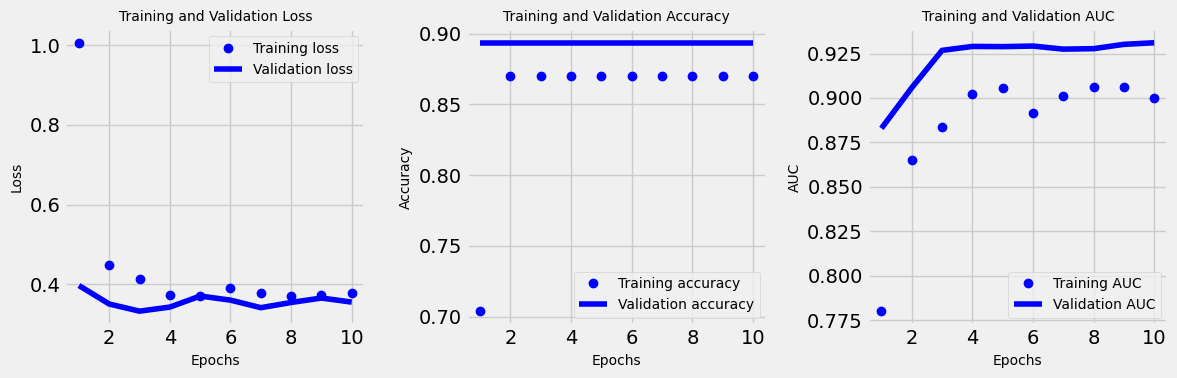

In [93]:
# Extracting data from the history object
history_dict = hist.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['binary_accuracy']
val_accuracy = history_dict['val_binary_accuracy']
auc = history_dict['auc']
val_auc = history_dict['val_auc']

epochs = range(1, len(loss) + 1)

# Plotting the loss
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))

ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and Validation Loss', fontsize = 10)
ax1.set_xlabel('Epochs', fontsize = 10)
ax1.set_ylabel('Loss', fontsize = 10)
ax1.legend(fontsize = 10)

# Plotting the accuracy
ax2.plot(epochs, accuracy, 'bo', label='Training accuracy')
ax2.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy', fontsize = 10)
ax2.set_xlabel('Epochs', fontsize = 10)
ax2.set_ylabel('Accuracy', fontsize = 10)
ax2.legend(fontsize = 10)

# Plotting the auc
ax3.plot(epochs, auc, 'bo', label='Training AUC')
ax3.plot(epochs, val_auc, 'b', label='Validation AUC')
ax3.set_title('Training and Validation AUC', fontsize = 10)
ax3.set_xlabel('Epochs', fontsize = 10)
ax3.set_ylabel('AUC', fontsize = 10)
ax3.legend(fontsize = 10)

plt.tight_layout()
plt.show()

### Visualize the models loss for both the training and validation data.

# Model Validation
* I don't know what exactly is in the test dataset

In [95]:
# Load an image you want to classify from an image file
# I'm just getting 4 random dates where there are no wildfires and where there were wildfires
fire_1 = df_wildfires['ConvertedDate'][random.randrange(1,len(df_wildfires))]
fire_2 = df_wildfires['ConvertedDate'][random.randrange(1,len(df_wildfires))]
fire_3 = df_wildfires['ConvertedDate'][random.randrange(1,len(df_wildfires))]
fire_4 = df_wildfires['ConvertedDate'][random.randrange(1,len(df_wildfires))]
no_fire_1 = df_no_clouds_no_wildfires['ConvertedDate'][random.randrange(1,len(df_no_clouds_no_wildfires))]
no_fire_2 = df_no_clouds_no_wildfires['ConvertedDate'][random.randrange(1,len(df_no_clouds_no_wildfires))]
no_fire_3 = df_no_clouds_no_wildfires['ConvertedDate'][random.randrange(1,len(df_no_clouds_no_wildfires))]
no_fire_4 = df_no_clouds_no_wildfires['ConvertedDate'][random.randrange(1,len(df_no_clouds_no_wildfires))]

In [96]:
no_fire_validation_dates = [no_fire_1,no_fire_2,no_fire_3,no_fire_4]
fire_validation_dates = [fire_1,fire_2,fire_3,fire_4]

In [97]:
no_fire_validation_dates

['2010-04-18', '2011-04-01', '2015-02-18', '2012-09-15']

In [98]:
no_wildfire_images_validation = []

for i in no_fire_validation_dates:
    jpeg_file = images_wo_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    no_wildfire_images_validation.append(im)

In [99]:
wildfire_images_validation = []

for i in fire_validation_dates:
    jpeg_file = images_wo_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_validation.append(im)

#### Resize Images for prediction

In [100]:
from skimage.transform import resize

In [101]:
resized_images_no_fire = []

for i in range(len(no_wildfire_images_validation)):
    resized_images_no_fire.append(resize(no_wildfire_images_validation[i],(180,182,3)))

In [102]:
# These should all be No wildfire
actual_wildfire_predictions = []
for i in range(len(resized_images_no_fire)):
    actual_wildfire_predictions.append(model.predict(np.array([resized_images_no_fire[i]])))
#no_wildfire_prediction_1 = model.predict(np.array([resized_images_no_fire[0]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


In [103]:
actual_wildfire_predictions

[array([[0.95945716, 0.04054284]], dtype=float32),
 array([[0.9623689 , 0.03763111]], dtype=float32),
 array([[0.95497113, 0.04502888]], dtype=float32),
 array([[0.943013  , 0.05698698]], dtype=float32)]

### Look at the images to see if there should be no wildfire

#### Get the labeled images for the specified dates

In [104]:
# images_w_fire_labels_path = '/images/images_w_fire_labels/'
images_w_fire_labels_path = 'images/images_w_fire_labels/'

In [105]:
wildfire_images_w_label = []

for i in no_fire_validation_dates:
    jpeg_file = images_w_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_w_label.append(im)

In [106]:
actual_wildfire_predictions[0]

array([[0.95945716, 0.04054284]], dtype=float32)

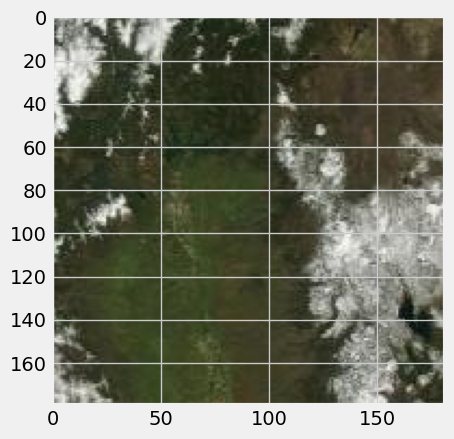

In [107]:
no_wildfire_image_0 = plt.imshow(no_wildfire_images_validation[0])

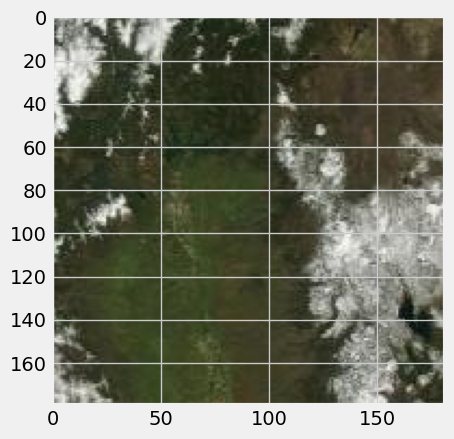

In [108]:
labeled_no_wildfire_image_0 = plt.imshow(wildfire_images_w_label[0])

In [109]:
actual_wildfire_predictions[1]

array([[0.9623689 , 0.03763111]], dtype=float32)

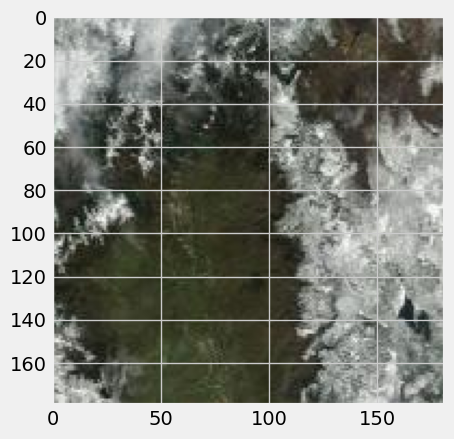

In [110]:
no_wildfire_image_1 = plt.imshow(no_wildfire_images_validation[1])

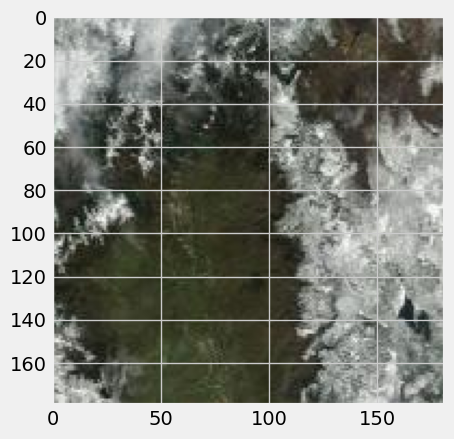

In [111]:
labeled_no_wildfire_image_1 = plt.imshow(wildfire_images_w_label[1])

In [112]:
actual_wildfire_predictions[2]

array([[0.95497113, 0.04502888]], dtype=float32)

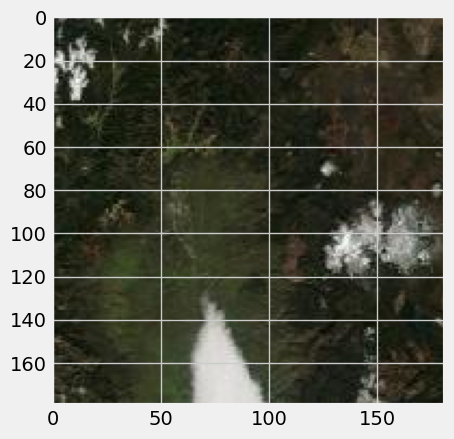

In [113]:
no_wildfire_image_2 = plt.imshow(no_wildfire_images_validation[2])

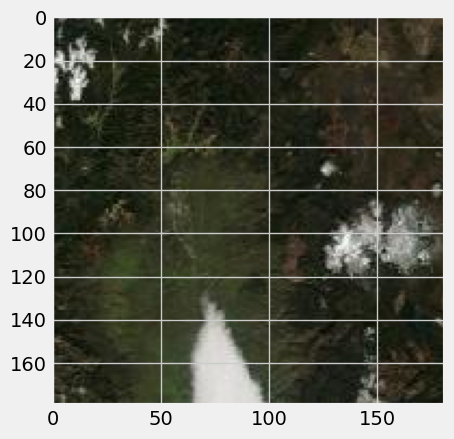

In [114]:
labeled_no_wildfire_image_2 = plt.imshow(wildfire_images_w_label[2])

In [115]:
actual_wildfire_predictions[3]

array([[0.943013  , 0.05698698]], dtype=float32)

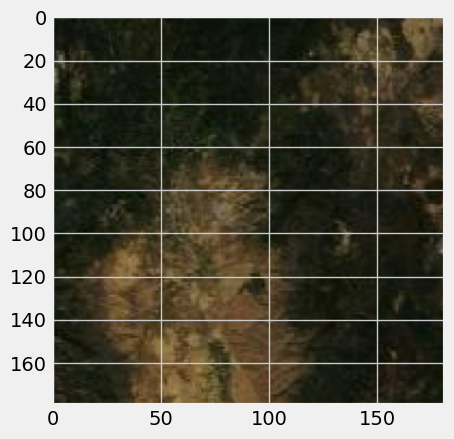

In [116]:
no_wildfire_image_3 = plt.imshow(no_wildfire_images_validation[3])

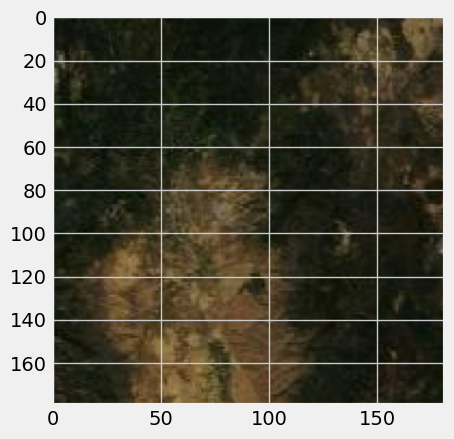

In [117]:
labeled_no_wildfire_image_3 = plt.imshow(wildfire_images_w_label[3])

### The below images were predicted to have wildfire and the labeled data should have the orange dot if there actually was a wildfire

In [118]:
resized_images_w_fire = []

for i in range(len(wildfire_images_validation)):
    resized_images_w_fire.append(resize(wildfire_images_validation[i],(180,182,3)))

In [119]:
# These should all be wildfire
actual_wildfire_predictions2 = []
for i in range(len(resized_images_w_fire)):
    actual_wildfire_predictions2.append(model.predict(np.array([resized_images_w_fire[i]])))
#no_wildfire_prediction_1 = model.predict(np.array([resized_images_no_fire[0]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


In [120]:
actual_wildfire_predictions2

[array([[0.7377887, 0.2622113]], dtype=float32),
 array([[0.8917767 , 0.10822327]], dtype=float32),
 array([[9.9925584e-01, 7.4416649e-04]], dtype=float32),
 array([[0.94603896, 0.05396103]], dtype=float32)]

#### Get the labeled data images

In [121]:
wildfire_images_w_label_2 = []

for i in fire_validation_dates:
    jpeg_file = images_w_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_w_label_2.append(im)

In [122]:
actual_wildfire_predictions2[0]

array([[0.7377887, 0.2622113]], dtype=float32)

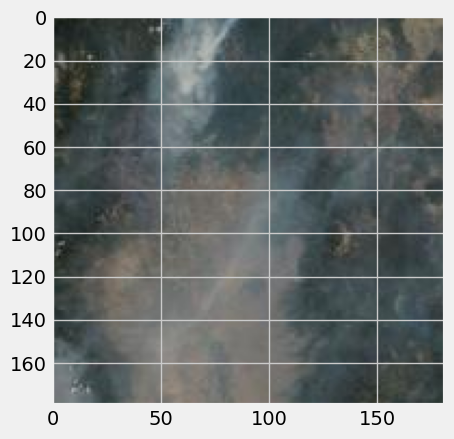

In [123]:
wildfire_image_0 = plt.imshow(wildfire_images_validation[0])

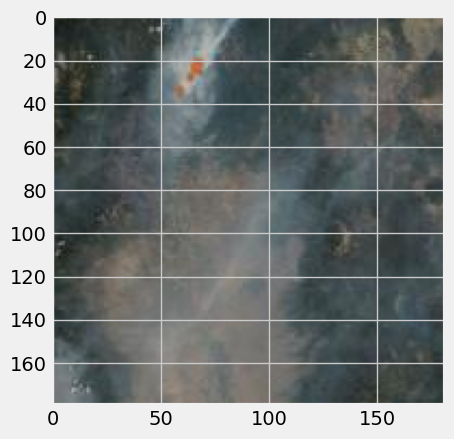

In [124]:
labeled_wildfire_image_0 = plt.imshow(wildfire_images_w_label_2[0])

In [125]:
actual_wildfire_predictions2[1]

array([[0.8917767 , 0.10822327]], dtype=float32)

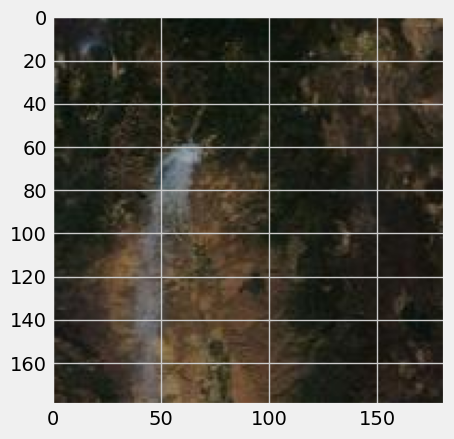

In [126]:
wildfire_image_1 = plt.imshow(wildfire_images_validation[1])

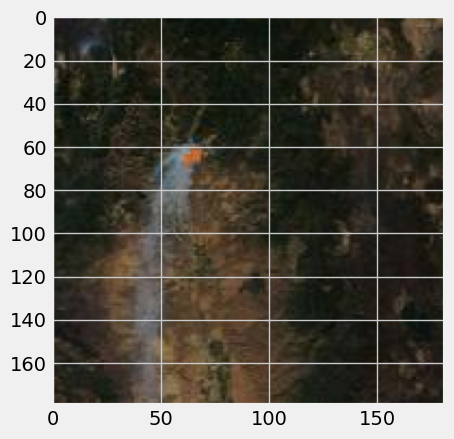

In [127]:
labeled_wildfire_image_1 = plt.imshow(wildfire_images_w_label_2[1])

In [128]:
actual_wildfire_predictions2[2]

array([[9.9925584e-01, 7.4416649e-04]], dtype=float32)

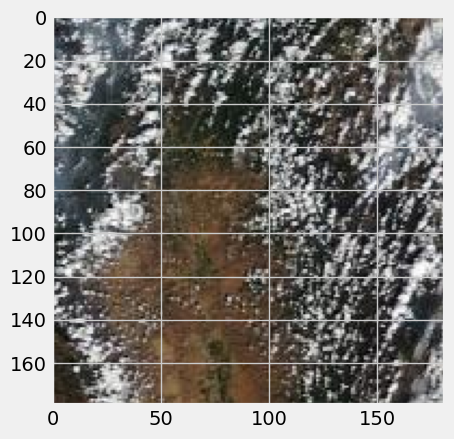

In [129]:
wildfire_image_2 = plt.imshow(wildfire_images_validation[2])

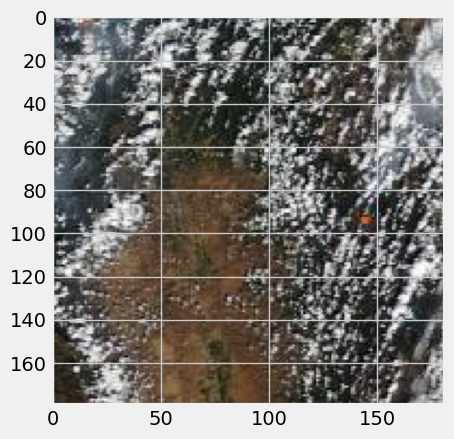

In [130]:
labeled_wildfire_image_2 = plt.imshow(wildfire_images_w_label_2[2])

In [131]:
actual_wildfire_predictions2[3]

array([[0.94603896, 0.05396103]], dtype=float32)

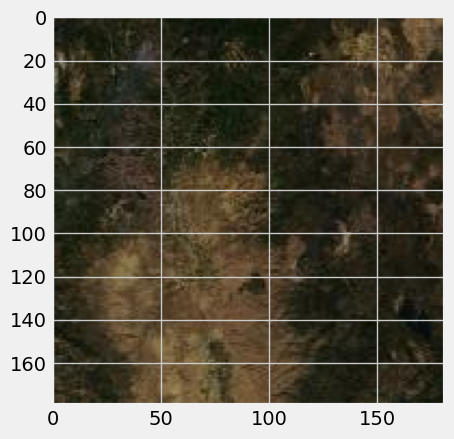

In [132]:
wildfire_image_3 = plt.imshow(wildfire_images_validation[3])

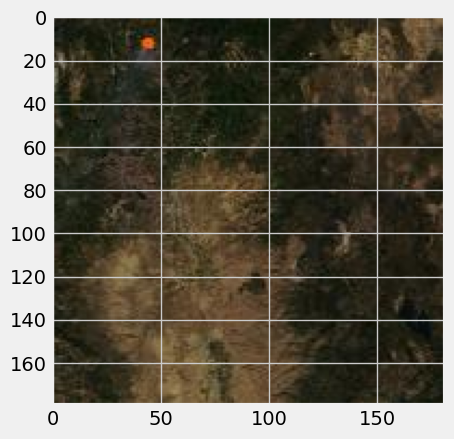

In [133]:
labeled_wildfire_image_3 = plt.imshow(wildfire_images_w_label_2[3])

In [144]:
# Compare it to the MLP Classifier
# Dates the mlp classifier used that had no wildfire

In [ ]:
# mlp classifier
# no_fire_validation_dates: ['2018-02-10', '2018-07-02', '2015-11-06', '2019-10-18']
# no_wildfire_images_validation
# on these dates there should be no wildfire
# This model gave these dates these predictions:
# [array([[0.853585, 0.146415]]),
#  array([[0.853585, 0.146415]]),
#  array([[0.853585, 0.146415]]),
#  array([[0.853585, 0.146415]])]

In [136]:
no_wildfire_images_validation = []

for i in ['2018-02-10', '2018-07-02', '2015-11-06', '2019-10-18']:
    jpeg_file = images_wo_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    no_wildfire_images_validation.append(im)

resized_images_no_fire = []

for i in range(len(no_wildfire_images_validation)):
    resized_images_no_fire.append(resize(no_wildfire_images_validation[i],(180,182,3)))

# These should all be No wildfire
actual_wildfire_predictions = []
for i in range(len(resized_images_no_fire)):
    actual_wildfire_predictions.append(model.predict(np.array([resized_images_no_fire[i]])))
#no_wildfire_prediction_1 = model.predict(np.array([resized_images_no_fire[0]]))

actual_wildfire_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[array([[0.86368376, 0.13631628]], dtype=float32),
 array([[0.9512658, 0.0487342]], dtype=float32),
 array([[0.90069777, 0.09930222]], dtype=float32),
 array([[0.9845152 , 0.01548476]], dtype=float32)]

In [137]:
# get the actual images to see if there is a wildfire
wildfire_images_w_label = []

for i in ['2018-02-10', '2018-07-02', '2015-11-06', '2019-10-18']:
    jpeg_file = images_w_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_w_label.append(im)

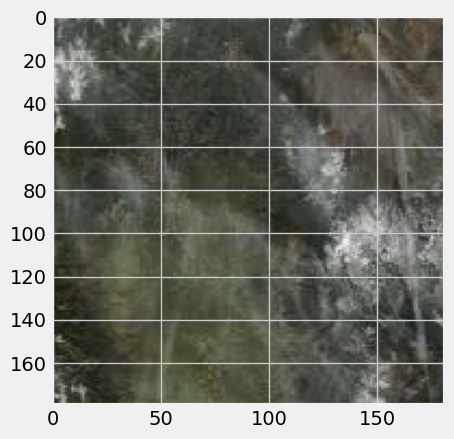

In [139]:
plt.imshow(wildfire_images_w_label[0])

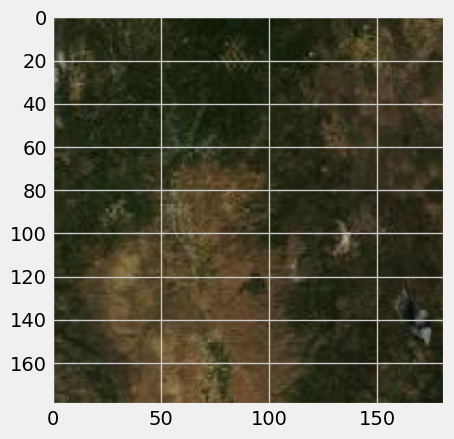

In [140]:
plt.imshow(wildfire_images_w_label[1])

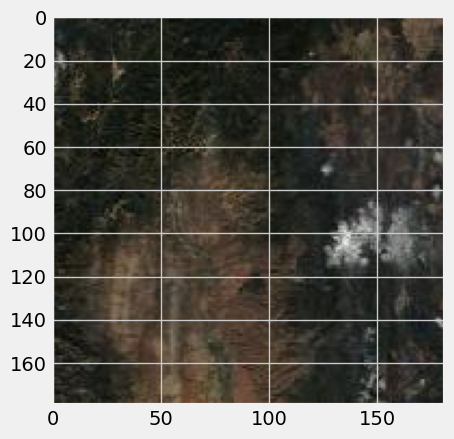

In [141]:
plt.imshow(wildfire_images_w_label[2])

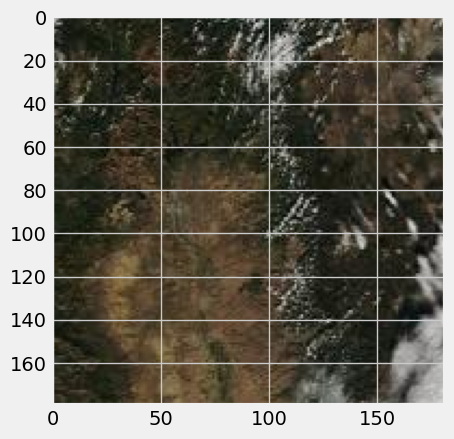

In [142]:
plt.imshow(wildfire_images_w_label[3])

### Save the Model

In [145]:
# 2/10/2025 11:09 am

In [ ]:
#model.save('nn_model.h5')

### Load the Model

In [ ]:
#from keras.models import load_model
#loaded_model = load_model('nn_model.h5')